In [1]:
import requests
import urbanpy as up
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import contextily as cx
from osmnx import project_gdf
from pandarallel import pandarallel
from tqdm.auto import tqdm

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=16)
tqdm.pandas()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
df_firmas = pd.read_csv("outputs/geocoded_df_ccpp.geojson.csv", index_col=0)

In [4]:
gdf = gpd.GeoDataFrame(
    data=df_firmas,
    geometry=gpd.points_from_xy(df_firmas['lon'], df_firmas['lat']),
    crs='EPSG:4326'
)

In [5]:
gdf.index

Int64Index([ 73740,  36523, 103983, 141261, 229733,  36147,  44749, 191355,
            192639, 165063,
            ...
            196544,   9914, 175906, 124772, 137779, 173828, 230068,  12497,
             12658, 227788],
           dtype='int64', length=191736)

In [6]:
gdf.shape

(191736, 14)

## Calculamos la distancia a infraestructura

In [7]:
infraestructura = pd.read_excel('inputs/Infraestructuras_Georef.xlsx', header=[0,1,2], index_col=0)

In [8]:
infraestructura.head()

Ubicación Geo-referenciada                                    \
                          Longitud              Latitud                
Infraes                          G   M        S       G   M        S   
1                              -76  57   9.3600     -12  11  40.0920   
2                              -71  30  38.6316     -16  24  55.3391   
3                              -77   7  23.1240     -11  59  52.1880   
4                              -73  15  43.1981      -3  45  57.6899   
5                              -72  52  56.8504     -13  37  56.8309   

        Ubicación geográfica                                        \
                Departamento          Provincia           Distrito   
Infraes   Unnamed: 7_level_2 Unnamed: 8_level_2 Unnamed: 9_level_2   
1                       LIMA               LIMA  VILLA EL SALVADOR   
2                   AREQUIPA           AREQUIPA         PAUCARPATA   
3                     CALLAO             CALLAO             CALLAO   
4                     LORETO             MAYNAS              BELEN   
5                   APURÍMAC            ABANCAY            ABANCAY   

        Codigo Centros Poblados Atendidos Nodo (9)  
                               Unnamed: 10_level_1  
Infraes                        Unnamed: 10_level_2  
1                                       1501420001  
2                                        401120001  
3                                        701010001  
4                                       1601120031  
5                                        301010001

### Validar que todas las coordenadas son negativas para aplicar la formula de conversion correspondiente

In [9]:
(infraestructura['Ubicación Geo-referenciada']['Longitud']['G'] >= 0).sum()

0

In [10]:
(infraestructura['Ubicación Geo-referenciada']['Latitud']['G'] >= 0).sum()

0

In [11]:
infraestructura['lon'] = \
infraestructura['Ubicación Geo-referenciada']['Longitud']['G'] - \
infraestructura['Ubicación Geo-referenciada']['Longitud']['M'] / 60 - \
infraestructura['Ubicación Geo-referenciada']['Longitud']['S'] / 3600

In [12]:
infraestructura['lat'] = \
infraestructura['Ubicación Geo-referenciada']['Latitud']['G'] - \
infraestructura['Ubicación Geo-referenciada']['Latitud']['M'] / 60 - \
infraestructura['Ubicación Geo-referenciada']['Latitud']['S'] / 3600

### Limpiamos los nombres de columnas

In [13]:
infraestructura = infraestructura.iloc[:,-6:]

In [14]:
infraestructura.head()

Ubicación geográfica                                        \
                Departamento          Provincia           Distrito   
Infraes   Unnamed: 7_level_2 Unnamed: 8_level_2 Unnamed: 9_level_2   
1                       LIMA               LIMA  VILLA EL SALVADOR   
2                   AREQUIPA           AREQUIPA         PAUCARPATA   
3                     CALLAO             CALLAO             CALLAO   
4                     LORETO             MAYNAS              BELEN   
5                   APURÍMAC            ABANCAY            ABANCAY   

        Codigo Centros Poblados Atendidos Nodo (9)        lon        lat  
                               Unnamed: 10_level_1                        
Infraes                        Unnamed: 10_level_2                        
1                                       1501420001 -76.952600 -12.194470  
2                                        401120001 -71.510731 -16.415372  
3                                        701010001 -77.123090 -11.997830  
4                                       1601120031 -73.261999  -3.766025  
5                                        301010001 -72.882458 -13.632453

In [15]:
infraestructura.columns = ['Departamento', 'Provincia', 'Distrito', 'CCPP Atendidos Nodo (9)', 'lon', 'lat']

In [16]:
infraestructura.head()

,Departamento,Provincia,Distrito,CCPP Atendidos Nodo (9),lon,lat
1,LIMA,LIMA,VILLA EL SALVADOR,1501420001,-76.952600,-12.194470
2,AREQUIPA,AREQUIPA,PAUCARPATA,401120001,-71.510731,-16.415372
3,CALLAO,CALLAO,CALLAO,701010001,-77.123090,-11.997830
4,LORETO,MAYNAS,BELEN,1601120031,-73.261999,-3.766025
5,APURÍMAC,ABANCAY,ABANCAY,301010001,-72.882458,-13.632453


### Calculamos las distancias de cada firma a la infraestructura mas cercana

In [17]:
# Get distance and indexes from nearest points 
dist, ind = up.utils.nn_search(
    tree_features = infraestructura[['lat', 'lon']].values, # Point of Interest
    query_features = gdf[['lat', 'lon']].values, # Hexagon
    metric='manhattan' # Distance metric
)

In [18]:
# Add nearest index
gdf['nearest_infraestucture_ix'] = ind

In [19]:
gdf['nearest_infraestucture_distance_km'] = dist

In [20]:
gdf['nearest_infraestucture_distance_km'].describe()

count    191736.000000
mean          0.023102
std           0.078083
min           0.000079
25%           0.006588
50%           0.011163
75%           0.017508
max           4.779266
Name: nearest_infraestucture_distance_km, dtype: float64

<AxesSubplot:>

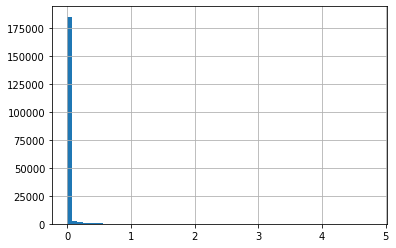

In [21]:
gdf['nearest_infraestucture_distance_km'].hist(bins=60)

### ¿Cual es el porcentaje de observaciones donde la infraestuctura más cercana está dentro del centro poblado de la firma?

In [22]:
# Cargamos los datos de CCPP
ccpp_osiptel = gpd.read_file('inputs/cp_osiptel')

In [23]:
# Convertimos nuestro dataframa a geodataframe
infra_gdf = gpd.GeoDataFrame(
    data=infraestructura,
    geometry=gpd.points_from_xy(infraestructura['lon'], infraestructura['lat']),
    crs='epsg:4326'
)

In [24]:
# Asignamos un CP a cada infraestructura (interseccion)
infra_gdf_ccpp = infra_gdf.sjoin(ccpp_osiptel, how='left', rsuffix='ccpp')

In [25]:
# Verificamos que los indices se hayan mantenido
(infra_gdf_ccpp.index == infra_gdf.index).all()

True

In [26]:
# Unimos las columnas de CP de la firma (index_right) y CP de la infraestuctura ('index_ccpp') usando 
# como clave el indice de la infraestructura
validate_ccpp = gdf[['nearest_infraestucture_ix', 'index_right']].merge(
    infra_gdf_ccpp.reset_index()[['index_ccpp']],
    how='left',
    left_on='nearest_infraestucture_ix',
    right_index=True,
)

In [27]:
# Veamos cuantos indices no faltan
validate_ccpp['index_ccpp'].isna().sum()

1491

In [28]:
# Compara si los indices de CP son iguales (la infraestructura esta dentro del mismo CP que la firma)
infra_in_ccpp = validate_ccpp['index_right'] == validate_ccpp['index_ccpp']

In [29]:
# Conteo y porcentajes de coincidencia en CP
infra_in_ccpp.value_counts(), infra_in_ccpp.value_counts(normalize=True) * 100

(True     141222
 False     50514
 dtype: int64,
 True     73.6544
 False    26.3456
 dtype: float64)

In [30]:
infra_in_ccpp.shape, gdf.shape

((191736,), (191736, 16))

In [31]:
# Verificamos la integridad de los indices
(infra_in_ccpp.index == gdf.index).all()

True

In [32]:
# Agregamos la variable flag 
gdf['infra_in_ccpp'] = infra_in_ccpp.values

### Ahora usemos los poligonos de CCPP Osiptel para filtrar el espacio de busqueda de infraestructuras

In [33]:
# Infraestructuras que caen dentro de un poligono
infra_gdf.sjoin(ccpp_osiptel).shape[0], infra_gdf.shape[0], round(infra_gdf.sjoin(ccpp_osiptel).shape[0]/infra_gdf.shape[0]*100,2)

(1180, 1253, 94.17)

In [34]:
# UTM projection is needed to calculate distance in meters
ccpp_osiptel_proj = project_gdf(ccpp_osiptel)
gdf_proj = gdf.to_crs(ccpp_osiptel_proj.crs)
infra_gdf_proj = infra_gdf.to_crs(ccpp_osiptel_proj.crs)

In [35]:
# Asigna un CCPP a cada infraestructura (interseccion)
infra_gdf_proj_ccpp = infra_gdf_proj.sjoin(ccpp_osiptel_proj)

In [36]:
def search_infra_wihin_ccpp(row):
    ccpp_ix = row['index_right'] # Indice del CCPP mas cercano
    
    if pd.isna(ccpp_ix):
        return np.nan, np.nan
    
    # Infraestructuras dentro del CCPP mas cercano
    infra_f = infra_gdf_proj_ccpp[infra_gdf_proj_ccpp['index_right'] == ccpp_ix]
    
    if infra_f.shape[0] == 0:
        return np.nan, np.nan
    
    # Calcula las distancias de la firma a las infraestructuras dentro del CCPP   
    ind, dist = infra_f.sindex.nearest(row.geometry, max_distance=3080*1000, return_all=False, return_distance=True)
    
    index = infra_f.iloc[ind[1][0]].name
    
    # Retorna el indice y la distancia minima
    return infra_f.iloc[ind[1][0]].name, dist[0]

In [37]:
start = time.time()
ixs_distances = gdf_proj.parallel_apply(search_infra_wihin_ccpp, axis=1, result_type='expand')
print("Elapsed time:", time.time()-start, "seconds")

Elapsed time: 80.03945398330688 seconds


In [38]:
ixs_distances.shape

(191736, 2)

In [39]:
gdf.shape

(191736, 17)

In [40]:
# Verificamos la integridad de los indices
(ixs_distances.index == gdf.index).all()

True

In [41]:
ixs_distances = ixs_distances.rename(columns={0: 'nearest_infra_in_ccpp_ix', 
                                              1: 'nearest_infra_in_ccpp_distance'})

<AxesSubplot:>

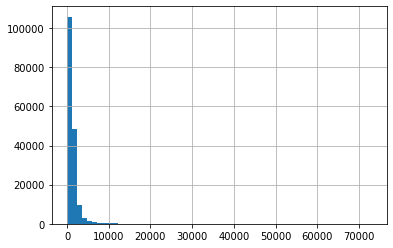

In [42]:
ixs_distances['nearest_infra_in_ccpp_distance'].hist(bins=60)

In [43]:
# Asignamos las nuevas variables
gdf[['nearest_infra_in_ccpp_ix', 'nearest_infra_in_ccpp_distance']] = ixs_distances

### Visualicemos los resultados para validar 

nearest_infra_in_ccpp_ix          901.000000
nearest_infra_in_ccpp_distance      7.396114
Name: 151513, dtype: float64


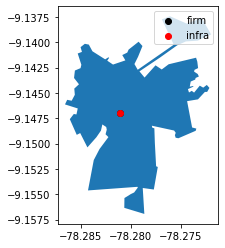

nearest_infra_in_ccpp_ix          277.000000
nearest_infra_in_ccpp_distance      7.527917
Name: 64729, dtype: float64


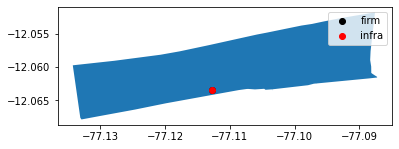

nearest_infra_in_ccpp_ix          343.000000
nearest_infra_in_ccpp_distance      8.657633
Name: 234136, dtype: float64


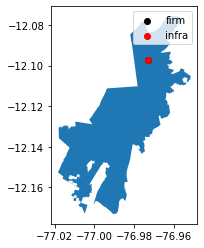

nearest_infra_in_ccpp_ix          343.000000
nearest_infra_in_ccpp_distance      8.657633
Name: 102532, dtype: float64


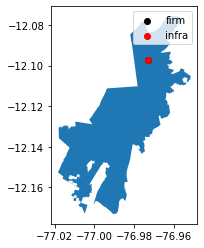

nearest_infra_in_ccpp_ix          343.000000
nearest_infra_in_ccpp_distance      8.657633
Name: 204711, dtype: float64


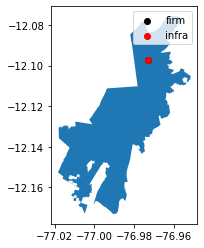

nearest_infra_in_ccpp_ix            674.000000
nearest_infra_in_ccpp_distance    47884.071268
Name: 52827, dtype: float64


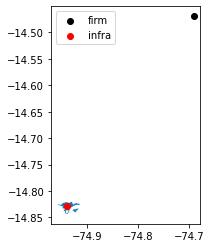

nearest_infra_in_ccpp_ix           1037.000000
nearest_infra_in_ccpp_distance    50282.168734
Name: 144829, dtype: float64


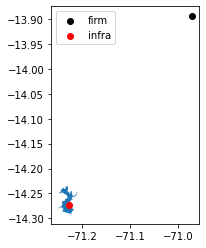

nearest_infra_in_ccpp_ix             37.00000
nearest_infra_in_ccpp_distance    51469.78553
Name: 16965, dtype: float64


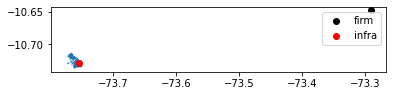

nearest_infra_in_ccpp_ix             37.00000
nearest_infra_in_ccpp_distance    51469.78553
Name: 15506, dtype: float64


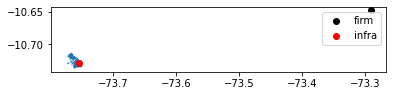

nearest_infra_in_ccpp_ix            664.000000
nearest_infra_in_ccpp_distance    72975.278194
Name: 199540, dtype: float64


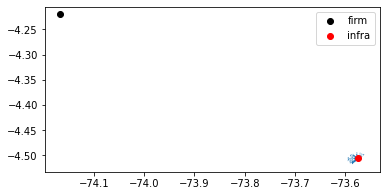

In [44]:
for n in ixs_distances.dropna().sort_values('nearest_infra_in_ccpp_distance').head(5).index:
    ax = ccpp_osiptel.loc[[gdf.loc[n]['index_right']]].plot(label='ccpp')
    gdf.loc[[n]].geometry.plot(ax=ax, color='k', label='firm')
    print(ixs_distances.loc[n])
    infra_gdf.loc[[ixs_distances.loc[n]['nearest_infra_in_ccpp_ix']]].plot(ax=ax, color='r', label='infra')
    plt.legend()
    plt.show()
    
for n in ixs_distances.dropna().sort_values('nearest_infra_in_ccpp_distance').tail(5).index:
    ax = ccpp_osiptel.loc[[gdf.loc[n]['index_right']]].plot(label='ccpp')
    gdf.loc[[n]].geometry.plot(ax=ax, color='k', label='firm')
    print(ixs_distances.loc[n])
    infra_gdf.loc[[ixs_distances.loc[n]['nearest_infra_in_ccpp_ix']]].plot(ax=ax, color='r', label='infra')
    plt.legend()
    plt.show()

## Descarga de aeropuertos

In [45]:
airports = gpd.read_file('inputs/aeropuerto.zip')

In [46]:
airports.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Cod_FACC    34 non-null     object  
 1   Cod_IGN     34 non-null     object  
 2   Rasgo_Prin  34 non-null     object  
 3   Categoria   34 non-null     object  
 4   Nombre      25 non-null     object  
 5   Distrito    34 non-null     object  
 6   Provincia   34 non-null     object  
 7   Departa     34 non-null     object  
 8   Cod_Hoja    34 non-null     object  
 9   Caracteris  34 non-null     object  
 10  Administra  34 non-null     object  
 11  Tipo_Super  34 non-null     object  
 12  X           34 non-null     float64 
 13  Y           34 non-null     float64 
 14  geometry    34 non-null     geometry
dtypes: float64(2), geometry(1), object(12)
memory usage: 4.1+ KB


In [47]:
airports.head()

,Cod_FACC,Cod_IGN,Rasgo_Prin,Categoria,Nombre,Distrito,Provincia,Departa,Cod_Hoja,Caracteris,Administra,Tipo_Super,X,Y,geometry
0,GB005,T0020,AEROPUERTO,ALTERNO,None,PUTUMAYO,MAYNAS,LORETO,1-m,EN CONSTRUCCIÓN,Desconocido,SUPERFÍCIE SUAVE,-75.245390,-0.123544,POINT (-75.24539 -0.12354)
1,GB005,T0020,AEROPUERTO,ALTERNO,ANTA,ANTA,CARHUÁS,ANCASH,19-h,Mas de 800 m. Largo,CORPAC S.A,SUPERFÍCIE DURA,-77.597732,-9.348183,POINT (-77.59773 -9.34818)
2,GB005,T0020,AEROPUERTO,ALTERNO,CHACHAPOYAS,CHACHAPOYAS,CHACHAPOYAS,AMAZONAS,13-h,Mas de 800 m. Largo,CORPAC S.A,SUPERFÍCIE SUAVE,-77.856801,-6.201721,POINT (-77.85680 -6.20172)
3,GB005,T0020,AEROPUERTO,INTERNACIONAL - SOLO COMO,BASE AÉREA DE PISCO (FAP),PARACAS,PISCO,ICA,28-k,Mas de 800 m. Largo,CORPAC S.A,SUPERFÍCIE DURA,-76.222186,-13.745007,POINT (-76.22219 -13.74501)
4,GB005,T0020,AEROPUERTO,ALTERNO,None,JUANJUÍ,MARISCAL CÁCERES,SAN MARTÍN,15-j,Mas de 800 m. Largo,CORPAC S.A,SUPERFÍCIE SUAVE,-76.728548,-7.169682,POINT (-76.72855 -7.16968)


In [48]:
# Get distance and indexes from nearest points 
dist, ind = up.utils.nn_search(
    tree_features = airports[['Y', 'X']].values, # Point of Interest
    query_features = gdf[['lat', 'lon']].values, # Hexagon
    metric='haversine' # Distance metric
)
# Add nearest health facility index to the hexagon gdf
gdf['nearest_airports_ix'] = ind
gdf['nearest_airports_distance_km'] = dist

# TODO: Distancia respecto al Puerto del Callao

In [49]:
gdf['nearest_airports_distance_km'].describe()

count    191736.000000
mean         22.321819
std          33.334685
min           0.043287
25%           6.960482
50%          11.859614
75%          18.845717
max         237.548675
Name: nearest_airports_distance_km, dtype: float64

<AxesSubplot:>

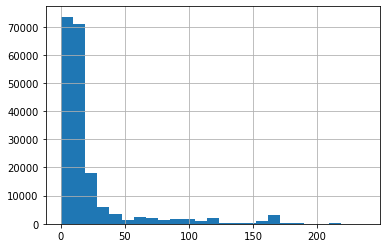

In [50]:
gdf['nearest_airports_distance_km'].hist(bins=25)

### Distancia respecto a Jorge Chavez

In [51]:
jorge_chavez = airports[airports['Distrito'] == 'CALLAO']
jorge_chavez

,Cod_FACC,Cod_IGN,Rasgo_Prin,Categoria,Nombre,Distrito,Provincia,Departa,Cod_Hoja,Caracteris,Administra,Tipo_Super,X,Y,geometry
7,GB005,T0020,AEROPUERTO,INTERNACIONAL,INETERNACIONAL JORGE CHÁVEZ,CALLAO,CALLAO,LIMA,25-i,Mas de 800 m. Largo,CORPAC S.A,SUPERFÍCIE DURA,-77.110229,-12.023098,POINT (-77.11023 -12.02310)


In [52]:
# Get distance and indexes from nearest points 
dist, ind = up.utils.nn_search(
    tree_features = jorge_chavez[['Y', 'X']].values, # Point of Interest
    query_features = gdf[['lat', 'lon']].values, # Hexagon
    metric='haversine' # Distance metric
)
# Add nearest health facility index to the hexagon gdf
gdf['distance_km_to_jorge_chavez_airport'] = dist

## Descarga de puertos

In [53]:
ports = gpd.read_file('inputs/puerto.zip')

In [54]:
ports.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Cod_FACC    33 non-null     object  
 1   Cod_IGN     33 non-null     object  
 2   Rasgo_Prin  33 non-null     object  
 3   Rasgo_Secu  33 non-null     object  
 4   Categoria   33 non-null     object  
 5   Distrito    33 non-null     object  
 6   Provincia   33 non-null     object  
 7   Departa     33 non-null     object  
 8   Cod_Hoja    33 non-null     object  
 9   X           33 non-null     float64 
 10  Y           33 non-null     float64 
 11  geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 3.2+ KB


In [55]:
ports.head()

,Cod_FACC,Cod_IGN,Rasgo_Prin,Rasgo_Secu,Categoria,Distrito,Provincia,Departa,Cod_Hoja,X,Y,geometry
0,BB005,H0280,PUERTO,MARÍTIMO,MENOR,MARCONA,NAZCA,ICA,31-m,-75.159847,-15.357865,POINT (-75.15985 -15.35786)
1,BB005,H0280,PUERTO,MARÍTIMO,MENOR,CHANCAY,HUARAL,LIMA,24-i,-77.274030,-11.584820,POINT (-77.27403 -11.58482)
2,BB005,H0280,PUERTO,MARÍTIMO,MENOR,HUACHO,HUARAL,LIMA,23-h,-77.614353,-11.123276,POINT (-77.61435 -11.12328)
3,BB005,H0280,PUERTO,MARÍTIMO,MENOR,SUPE PUERTO,BARRANCA,LIMA,22-h,-77.745241,-10.800293,POINT (-77.74524 -10.80029)
4,BB005,H0280,PUERTO,MARÍTIMO,MENOR - CALETA,BARRANCA,BARRANCA,LIMA,22-h,-77.762490,-10.767458,POINT (-77.76249 -10.76746)


In [56]:
# Get distance and indexes from nearest points 
dist, ind = up.utils.nn_search(
    tree_features = ports[['Y', 'X']].values, # Point of Interest
    query_features = gdf[['lat', 'lon']].values, # Hexagon
    metric='haversine' # Distance metric
)
# Add nearest health facility index to the hexagon gdf
gdf['nearest_ports_ix'] = ind
gdf['nearest_ports_distance_km'] = dist

In [57]:
gdf['nearest_ports_distance_km'].describe()

count    191736.000000
mean         57.659447
std          85.095898
min           0.080503
25%          13.024669
50%          19.461194
75%          66.660129
max         654.502156
Name: nearest_ports_distance_km, dtype: float64

<AxesSubplot:>

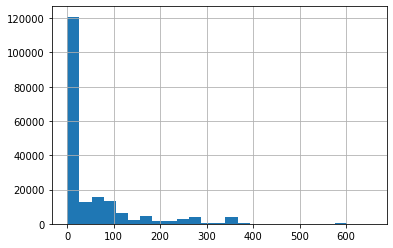

In [58]:
gdf['nearest_ports_distance_km'].hist(bins=25)

### Distance to Puerto del Callao

In [59]:
puerto_callao = ports[ports['Distrito'] == 'CALLAO']
puerto_callao

,Cod_FACC,Cod_IGN,Rasgo_Prin,Rasgo_Secu,Categoria,Distrito,Provincia,Departa,Cod_Hoja,X,Y,geometry
10,BB005,H0280,PUERTO,MARÍTIMO,MAYOR,CALLAO,CALLAO,LIMA,25-i,-77.147782,-12.053085,POINT (-77.14778 -12.05309)


In [60]:
# Get distance and indexes from nearest points 
dist, ind = up.utils.nn_search(
    tree_features = puerto_callao[['Y', 'X']].values, # Point of Interest
    query_features = gdf[['lat', 'lon']].values, # Hexagon
    metric='haversine' # Distance metric
)
# Add nearest health facility index to the hexagon gdf
gdf['distance_km_to_callao_port'] = dist

## Distancia a Lima

In [61]:
lima = up.download.nominatim_osm('Plaza de Armas, Lima, Peru', expected_position=3)

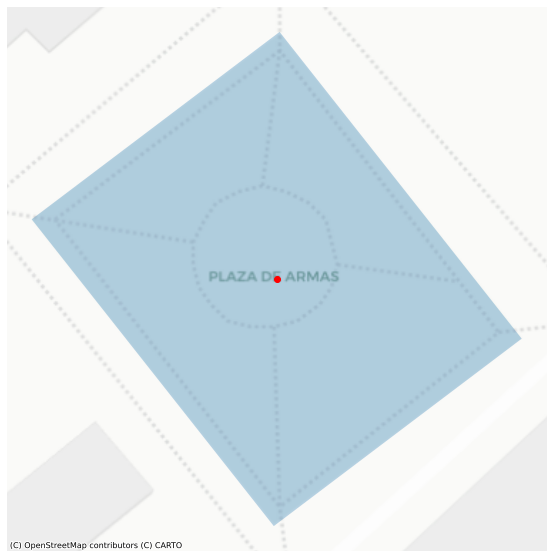

In [62]:
ax = lima.plot(figsize=(10,10), alpha=0.3)
lima.centroid.plot(ax=ax, color='r')
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Positron, zoom=20)
ax.set_axis_off()

In [63]:
# Get distance and indexes from Lima
dist, ind = up.utils.nn_search(
    tree_features = [[lima.centroid.iloc[0].y, lima.centroid.iloc[0].x]], # Point of Interest
    query_features = gdf[['lat', 'lon']].values, # Hexagon
    metric='haversine' # Distance metric
)

gdf['distance_km_to_lima'] = dist

In [64]:
gdf['distance_km_to_lima'].describe()

count    191736.000000
mean        275.790198
std         290.618154
min           0.004661
25%          73.403356
50%          77.693633
75%         507.904707
max        1289.464137
Name: distance_km_to_lima, dtype: float64

<AxesSubplot:>

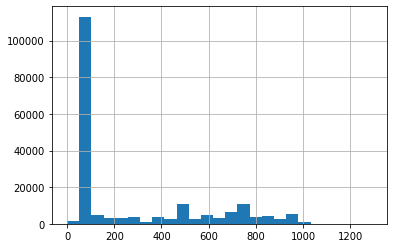

In [65]:
gdf['distance_km_to_lima'].hist(bins=25)

### Distancia al distrito de procedencia

In [66]:
rucs = pd.read_stata('inputs/rucs_firmas_20142020_v2.dta')

In [67]:
rucs.columns

Index(['ruc', 'RAZON_SOCIAL', 'NOMBRE_COMERCIAL', 'CODIGO_TIPO_VIA',
       'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'PUERTA', 'MANZANA', 'LOTE',
       'PISO', 'INTERIOR', 'DIR_DPTO', 'KILOMETRO', 'REFERENCIA',
       'DIR_TIPOZONA', 'tipo_zona', 'DIR_NOMZONA', 'CNS_UBIGEO',
       'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL', 'CNS_FRENTE',
       'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'CAPITAL', 'codigo_prov',
       'Region', 'CODODEI', 'ODEI', 'UBIGEO'],
      dtype='object')

In [68]:
distritos_peru = gpd.read_file('inputs/distritos/')

In [69]:
distritos_peru_proj = project_gdf(distritos_peru)

In [70]:
rucs.columns

Index(['ruc', 'RAZON_SOCIAL', 'NOMBRE_COMERCIAL', 'CODIGO_TIPO_VIA',
       'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'PUERTA', 'MANZANA', 'LOTE',
       'PISO', 'INTERIOR', 'DIR_DPTO', 'KILOMETRO', 'REFERENCIA',
       'DIR_TIPOZONA', 'tipo_zona', 'DIR_NOMZONA', 'CNS_UBIGEO',
       'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL', 'CNS_FRENTE',
       'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'CAPITAL', 'codigo_prov',
       'Region', 'CODODEI', 'ODEI', 'UBIGEO'],
      dtype='object')

In [71]:
rucs.head()

,ruc,RAZON_SOCIAL,NOMBRE_COMERCIAL,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,...,CNS_FRENTE,DEPARTAMENTO,PROVINCIA,DISTRITO,CAPITAL,codigo_prov,Region,CODODEI,ODEI,UBIGEO
0,2.010000e+10,COCINA DE VUELO DOCAMPO S.A.C.,-,03,JIRON,APURIMAC,521,-,-,,...,,CALLAO,CALLAO,CALLAO,CALLAO,0701,07 Callao,15,Lima,070101
1,2.010000e+10,COMFER S A,,01,AVENIDA,ARGENTINA,1646,-,-,,...,,CALLAO,CALLAO,CALLAO,CALLAO,0701,07 Callao,15,Lima,070101
2,2.010000e+10,CROSLAND TECNICA S.A.,-,01,AVENIDA,AUGUSTO PEREZ ARANIBAR,1872,-,-,,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
3,2.010000e+10,FUNDICION CALLAO S.A.,,01,AVENIDA,ARGENTINA,3719,-,-,,...,,CALLAO,CALLAO,CALLAO,CALLAO,0701,07 Callao,15,Lima,070101
4,2.010000e+10,KOMFORT S A,-,05,CARRETERA,ANTIGUA PANAMERICANA SUR,-,-,-,,...,,LIMA,LIMA,VILLA EL SALVADOR,VILLA EL SALVADOR,1501,15 Provincia de Lima,15,Lima,150142


In [72]:
distritos_peru_proj.columns

Index(['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO',
       'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE', 'geometry'],
      dtype='object')

In [73]:
distritos_peru_proj.head()

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((465079.270 -1027514.387, 465174.520 ..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((539439.186 -975305.103, 539548.429 -..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((497522.027 -966320.757, 497506.328 -..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((484744.000 -946997.000, 484642.260 -..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((498251.163 -933645.324, 498255.086 -..."


In [74]:
rucs_with_district_polygon = rucs.loc[gdf.index].merge(
    distritos_peru_proj[['IDPROV', 'DISTRITO', 'geometry']], 
    how='left',
    left_on=['codigo_prov', 'DISTRITO'], 
    right_on=['IDPROV', 'DISTRITO'])

In [75]:
rucs_with_district_polygon = gpd.GeoDataFrame(rucs_with_district_polygon, 
                                              crs=distritos_peru_proj.crs)

In [76]:
gdf.shape, rucs_with_district_polygon.shape

((191736, 26), (191736, 33))

In [77]:
gdf_proj = project_gdf(gdf)

In [78]:
distritos_peru_proj.crs == gdf_proj.crs

True

In [79]:
# Calculamos la distancia de la firma al distrito correspondiente
distance_to_district_meters = gdf_proj.distance(rucs_with_district_polygon['geometry'],
                                                align=False)

In [80]:
distance_to_district_km = distance_to_district_meters / 1000

In [81]:
gdf['distance_km_to_district'] = distance_to_district_km 

In [82]:
gdf['distance_km_to_district'].describe()

count    191602.000000
mean         15.427364
std         110.365145
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1832.415902
Name: distance_km_to_district, dtype: float64

<AxesSubplot:>

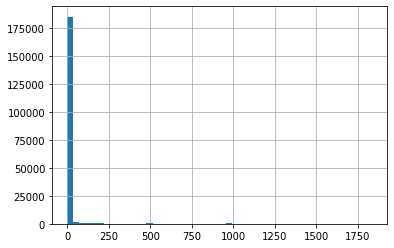

In [83]:
gdf['distance_km_to_district'].hist(bins=50)

In [84]:
# Verifiquemos los missing values
gdf['distance_km_to_district'].isna().sum(), round(gdf['distance_km_to_district'].isna().sum() / gdf.shape[0] * 100, 2)

(134, 0.07)

### Listo! Ahora vamos a guardar las variables calculadas

In [85]:
gdf.columns

Index(['IDMANZANA', 'lon', 'lat', 'dataset', 'place_id', 'osm_type', 'osm_id',
       'display_name', 'class', 'type', 'geometry', 'index_right', 'Name',
       'distance_to_cp', 'nearest_infraestucture_ix',
       'nearest_infraestucture_distance_km', 'infra_in_ccpp',
       'nearest_infra_in_ccpp_ix', 'nearest_infra_in_ccpp_distance',
       'nearest_airports_ix', 'nearest_airports_distance_km',
       'distance_km_to_jorge_chavez_airport', 'nearest_ports_ix',
       'nearest_ports_distance_km', 'distance_km_to_callao_port',
       'distance_km_to_lima', 'distance_km_to_district'],
      dtype='object')

In [86]:
gdf = gdf.rename(columns={'index_right': 'cp_index'}) # Indice de CP
gdf['firm_in_cp'] = (gdf['distance_to_cp'] == 0).astype(int) # Flag indicando si la firma esta dentro del CP (1) o no (0)

# Coloquemos las distanciasen km por consistencia
gdf['distance_km_to_cp'] = gdf['distance_to_cp'] / 1000 
gdf['nearest_infra_in_ccpp_distance_km'] = gdf['nearest_infra_in_ccpp_distance'] / 1000

In [104]:
relevant_vars = [
# Centro Poblado
'cp_index', 'distance_km_to_cp', 'firm_in_cp',

# Infraestuctura
'nearest_infraestucture_ix', 'nearest_infraestucture_distance_km', 'infra_in_ccpp',
'nearest_infra_in_ccpp_ix', 'nearest_infra_in_ccpp_distance_km',

# Aeropuertos
'nearest_airports_ix', 'nearest_airports_distance_km',
'distance_km_to_jorge_chavez_airport',

'nearest_ports_ix', 'nearest_ports_distance_km',
'distance_km_to_callao_port', 

# Lugares de referencia
'distance_km_to_lima', 'distance_km_to_district',
    
# Variables de OSM
'place_id', 'osm_id', 'osm_type', 'class', 'type', 'display_name', 
    
# Variables geograficas
'IDMANZANA', 'dataset', 'lon', 'lat', 'geometry',
]

### Ahora añadiremos al dataset original las nuevas columnas

In [105]:
rucs_final_df = rucs.merge(gdf[relevant_vars], how='left', left_index=True, right_index=True)

In [106]:
rucs_final_df.columns

Index(['ruc', 'RAZON_SOCIAL', 'NOMBRE_COMERCIAL', 'CODIGO_TIPO_VIA',
       'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'PUERTA', 'MANZANA', 'LOTE',
       'PISO', 'INTERIOR', 'DIR_DPTO', 'KILOMETRO', 'REFERENCIA',
       'DIR_TIPOZONA', 'tipo_zona', 'DIR_NOMZONA', 'CNS_UBIGEO',
       'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL', 'CNS_FRENTE',
       'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'CAPITAL', 'codigo_prov',
       'Region', 'CODODEI', 'ODEI', 'UBIGEO', 'cp_index', 'distance_km_to_cp',
       'firm_in_cp', 'nearest_infraestucture_ix',
       'nearest_infraestucture_distance_km', 'infra_in_ccpp',
       'nearest_infra_in_ccpp_ix', 'nearest_infra_in_ccpp_distance_km',
       'nearest_airports_ix', 'nearest_airports_distance_km',
       'distance_km_to_jorge_chavez_airport', 'nearest_ports_ix',
       'nearest_ports_distance_km', 'distance_km_to_callao_port',
       'distance_km_to_lima', 'distance_km_to_district', 'place_id', 'osm_id',
       'osm_type', 'class', 'type', 'di

In [107]:
# Guardemos los datos en formato plano (CSV)
rucs_final_df.drop('geometry', axis=1).to_csv('outputs/rucs_final_df.csv')

In [111]:
from pandas_profiling import ProfileReport

In [112]:
profile = ProfileReport(rucs_final_df.drop('geometry', axis=1))

In [117]:
profile.to_file('outputs/rucs_final_df_profile.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [114]:
minimal_profile = ProfileReport(rucs_final_df.drop('geometry', axis=1), minimal=True)

In [116]:
minimal_profile.to_file('outputs/rucs_final_df_minimal_profile.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
rucs_final_df.drop('geometry', axis=1)

In [108]:
rucs_final_gdf = gpd.GeoDataFrame(rucs_final_df, crs=gdf.crs)

In [109]:
# Guardemos los datos en formato geografico (GeoJSON)
(rucs_final_gdf
 .reset_index().rename(columns={'index': 'original_index'}) # Mantengamos el indice original
 .to_file('outputs/rucs_final_df.geojson', driver='GeoJSON') # Guardamos los datos como geojson
)

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### ¡Hagamos algunos mapas!

In [93]:
# Zona de analisis
departamentos = gpd.read_file('inputs/departamentos/')
res = 6
peru_hexs = up.geom.gen_hexagons(res, departamentos)
print(f'Hex count @ res {res}:', peru_hexs.shape[0])

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/urbanpy/geom/geom.py:168: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  city_poly = city.explode().reset_index(drop=True)


Hex count @ res 6: 31223


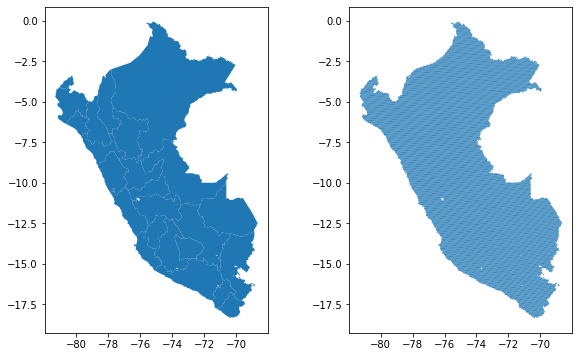

In [94]:
# Visualicemos el mapa de departamentos y hexagonos
fig, axes = plt.subplots(1, 2, figsize=(10,6))
departamentos.plot(ax=axes[0])
peru_hexs.plot(ax=axes[1])
plt.show()

In [95]:
distance_cols = gdf.columns[gdf.columns.str.contains('distance')]

In [96]:
distance_cols

Index(['distance_to_cp', 'nearest_infraestucture_distance_km',
       'nearest_infra_in_ccpp_distance', 'nearest_airports_distance_km',
       'distance_km_to_jorge_chavez_airport', 'nearest_ports_distance_km',
       'distance_km_to_callao_port', 'distance_km_to_lima',
       'distance_km_to_district', 'distance_km_to_cp',
       'nearest_infra_in_ccpp_distance_km'],
      dtype='object')

In [97]:
gdf[distance_cols].describe()

,distance_to_cp,nearest_infraestucture_distance_km,nearest_infra_in_ccpp_distance,nearest_airports_distance_km,distance_km_to_jorge_chavez_airport,nearest_ports_distance_km,distance_km_to_callao_port,distance_km_to_lima,distance_km_to_district,distance_km_to_cp,nearest_infra_in_ccpp_distance_km
count,191736.000000,191736.000000,170845.000000,191736.000000,191736.000000,191736.000000,191736.000000,191736.000000,191602.000000,191736.000000,170845.000000
mean,296.136361,0.023102,1359.134196,22.321819,248.957443,57.659447,251.390225,275.790198,15.427364,0.296136,1.359134
std,2408.907425,0.078083,1852.296902,33.334685,324.011144,85.095898,323.587372,290.618154,110.365145,2.408907,1.852297
min,0.000000,0.000079,7.396114,0.043287,0.079205,0.080503,0.609174,0.004661,0.000000,0.000000,0.007396
25%,0.000000,0.006588,548.050142,6.960482,11.730861,13.024669,14.369374,73.403356,0.000000,0.000000,0.548050
50%,0.000000,0.011163,976.612148,11.859614,20.187575,19.461194,22.380165,77.693633,0.000000,0.000000,0.976612
75%,0.000000,0.017508,1604.887998,18.845717,492.579409,66.660129,496.879597,507.904707,0.000000,0.000000,1.604888
max,257950.935806,4.779266,72975.278194,237.548675,1322.963784,654.502156,1327.072324,1289.464137,1832.415902,257.950936,72.975278


In [98]:
agg = {'distance_km_to_cp': 'mean',
       'nearest_infraestucture_distance_km': 'mean',
       'nearest_airports_distance_km': 'mean',
       'nearest_ports_distance_km': 'mean',
       'distance_km_to_lima': 'mean',
       'distance_km_to_district': 'mean',
       'count': 'sum'}

# Count points per hexagon
rucs_final_gdf['count'] = 1
peru_hexs_counts = up.geom.merge_shape_hex(peru_hexs, rucs_final_gdf, agg=agg)

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [99]:
minx, miny, maxx, maxy = peru_hexs.total_bounds

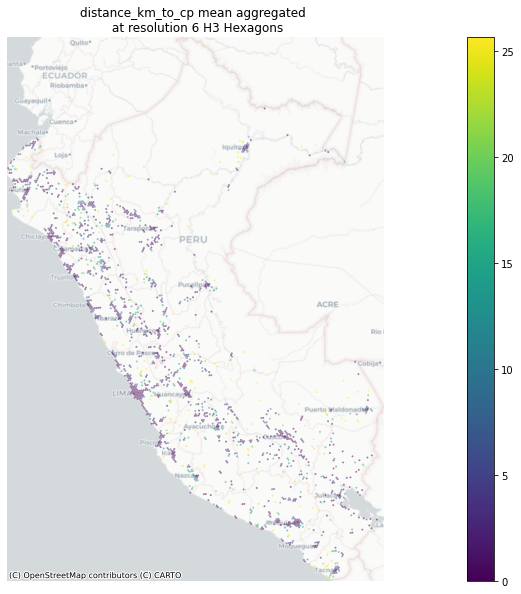

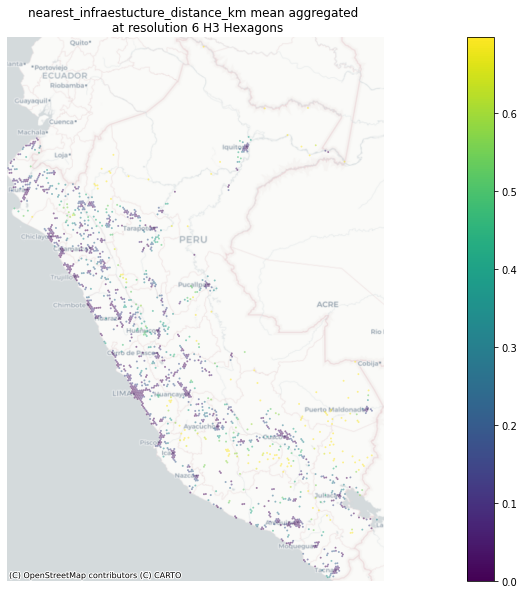

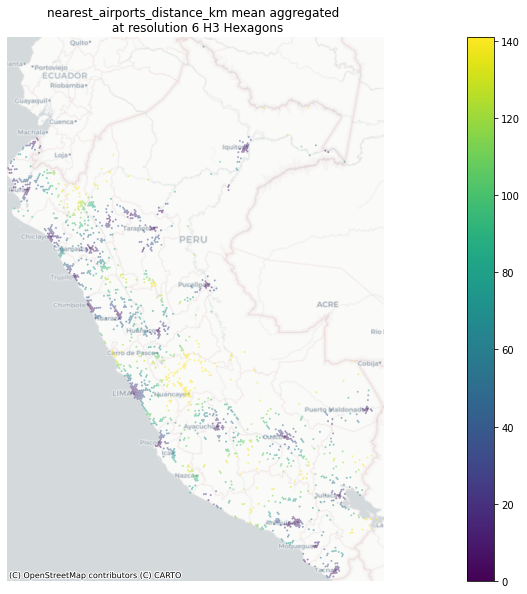

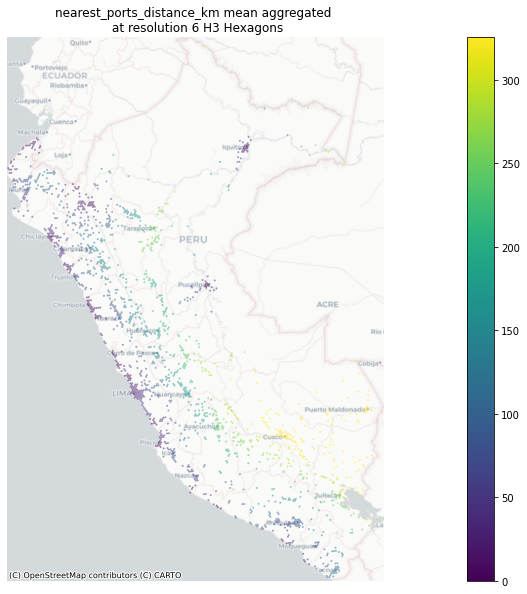

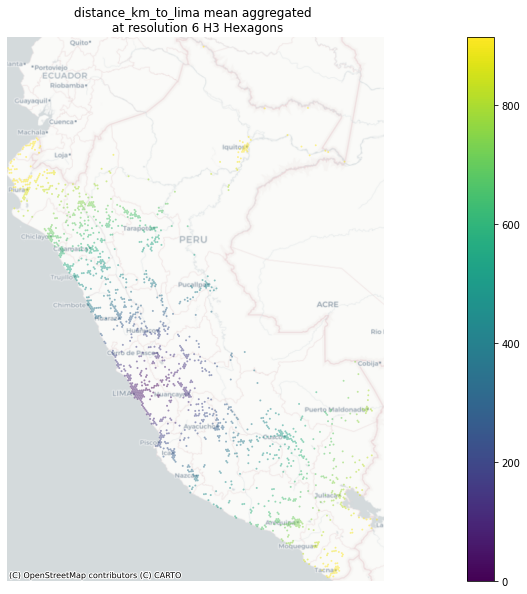

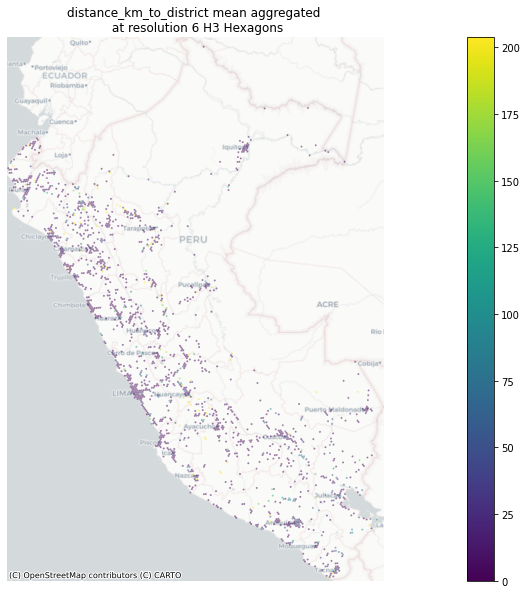

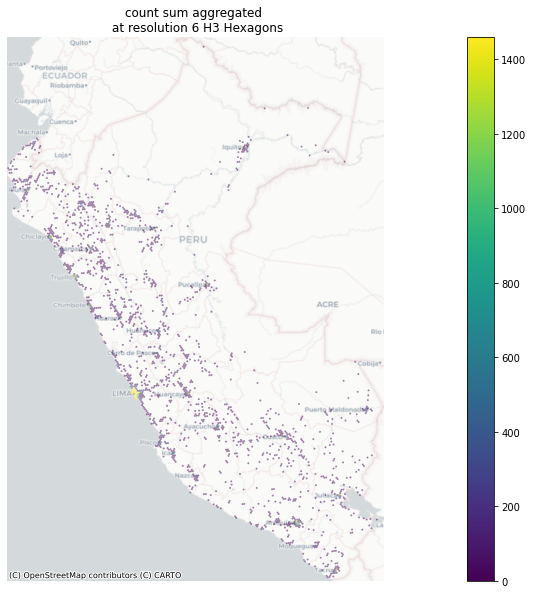

In [100]:
for col, agg_method in agg.items():
    vmax = peru_hexs_counts[col].mean() + (1.5 * peru_hexs_counts[col].std())
    
    ax = peru_hexs_counts.plot(col, vmin=0, vmax=vmax, figsize=(30,10),
                               legend=True, alpha=0.5, cmap='viridis')
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    cx.add_basemap(ax, crs=rucs_final_gdf.crs, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()
    ax.set_title(f'{col} {agg_method} aggregated \n at resolution {res} H3 Hexagons')
    plt.show()

### Mapa interactivo

In [101]:
peru_hexs_counts.dropna(subset='count').explore('nearest_infraestucture_distance_km', vmax=1, legend=True, 
                                                style_kwds={'weight':0.5}, cmap='viridis')